In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pathlib
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

seed = 30
tf.random.set_seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
#tunable parameters

SAMPLING_RATE = 44100

WINDOW_SIZE_SEC = 20
WINDOW_STRIDE_SEC = 1

STFT_FRAME_LENGTH = 255
STFT_FRAME_STEP = 128

BUFFER_SIZE = 1000

BATCH_SIZE = 16
EPOCHS = 100

In [4]:
data_path = '/tf/data/ADReSS-IS2020'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [5]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

In [6]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):    
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0]
    label = meta.MMSE[meta.ID == name + ' ']
    return label.tolist()

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram, label

In [8]:
def get_data_old(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    
    zero_padding = tf.zeros([10000000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram, label

def window(x, size, stride):
    length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range(int((length-size)/stride)+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(
        waveform, 
        size=SAMPLING_RATE*WINDOW_SIZE_SEC, 
        stride=SAMPLING_RATE*WINDOW_STRIDE_SEC)
    
    rolling_spectrograms = tf.signal.stft(
        rolling_waveform_tensors, 
        frame_length=STFT_FRAME_LENGTH, 
        frame_step=STFT_FRAME_STEP
    )
    
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, label

In [9]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(BUFFER_SIZE)\
                        .flat_map(lambda x,y: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.from_tensor_slices([y])
                        )))\
                        .shuffle(BUFFER_SIZE)
    return output_ds

In [10]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [11]:
for spectrogram, y in train_ds.take(1):
    input_shape = spectrogram.shape
    print(input_shape)
    print(y)

(6889, 129, 1)
tf.Tensor(28, shape=(), dtype=int64)


In [12]:
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

In [13]:
print('Input shape:', input_shape)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model.summary()

Input shape: (6889, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)               

In [14]:
model.compile(
    optimizer="adam",
    loss='mse',
    metrics='mse'
)

In [15]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS
)

Epoch 1/100
10/10 [==============================] - 21s 2s/step - loss: 489.7848 - mse: 489.7848 - val_loss: 303.3346 - val_mse: 303.3346
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 192.4019 - mse: 192.4019 - val_loss: 54.0556 - val_mse: 54.0556
Epoch 3/100
10/10 [==============================] - 0s 19ms/step - loss: 116.6137 - mse: 116.6137 - val_loss: 39.7091 - val_mse: 39.7091
Epoch 4/100
10/10 [==============================] - 0s 19ms/step - loss: 101.7605 - mse: 101.7605 - val_loss: 62.9291 - val_mse: 62.9291
Epoch 5/100
10/10 [==============================] - 0s 16ms/step - loss: 66.1491 - mse: 66.1491 - val_loss: 45.2380 - val_mse: 45.2380
Epoch 6/100
10/10 [==============================] - 0s 17ms/step - loss: 64.8562 - mse: 64.8562 - val_loss: 43.4219 - val_mse: 43.4219
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 67.1111 - mse: 67.1111 - val_loss: 45.8019 - val_mse: 45.8019
Epoch 8/100
10/10 [====================

Epoch 61/100
10/10 [==============================] - 0s 18ms/step - loss: 36.3264 - mse: 36.3264 - val_loss: 39.7107 - val_mse: 39.7107
Epoch 62/100
10/10 [==============================] - 0s 19ms/step - loss: 34.1017 - mse: 34.1017 - val_loss: 39.3801 - val_mse: 39.3801
Epoch 63/100
10/10 [==============================] - 0s 19ms/step - loss: 38.0932 - mse: 38.0932 - val_loss: 40.6368 - val_mse: 40.6368
Epoch 64/100
10/10 [==============================] - 0s 20ms/step - loss: 33.3439 - mse: 33.3439 - val_loss: 38.0787 - val_mse: 38.0787
Epoch 65/100
10/10 [==============================] - 0s 19ms/step - loss: 46.3274 - mse: 46.3274 - val_loss: 39.6515 - val_mse: 39.6515
Epoch 66/100
10/10 [==============================] - 0s 19ms/step - loss: 28.2833 - mse: 28.2833 - val_loss: 40.0584 - val_mse: 40.0584
Epoch 67/100
10/10 [==============================] - 0s 20ms/step - loss: 40.8321 - mse: 40.8321 - val_loss: 38.6279 - val_mse: 38.6279
Epoch 68/100
10/10 [=====================

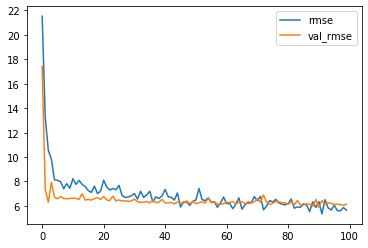

In [16]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mse']), np.sqrt(metrics['val_mse']))
plt.legend(['rmse', 'val_rmse'])
plt.show()